<a href="https://colab.research.google.com/github/s-mishra/statrethinking_lectures_numpyro/blob/main/week4/iwona_rethinking_week_4_chapter_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Useful links:

* [HOMEWORK](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework)

* [Book code translated into NumPyro](https://fehiepsi.github.io/rethinking-numpyro/)

* [Book and homework code in Python/PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking_2)

* [NumPyro documentation](http://num.pyro.ai/en/stable/api.html)

* [NumPyro examples](http://num.pyro.ai/en/latest/index.html#introductory-tutorials)

* [Other languagaes and videos](https://github.com/rmcelreath/stat_rethinking_2020)

In [1]:
!pip install numpyro


     |████████████████████████████████| 250 kB 28.9 MB/s 


In [2]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist

az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

import numpy as np
import pandas as pd

# Homework week 4

 https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework/week04

## Exercise 1


Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the birb population. They have each found the following proportions of 5 important birb species:
	
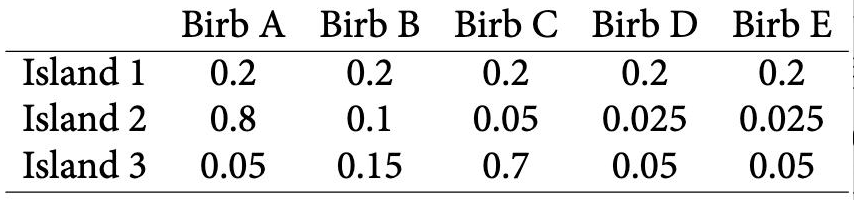
	 
	
Notice that each row sums to 1, all the birbs. This problem has two parts. It is not computationally complicated. But it is conceptually tricky. First, compute the entropy of each island’s birb distribution. Interpret these entropy values. Second, use each island’s birb distribution to predict the other two. This means to compute the K-L Divergence of each island from the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different K-L Divergence values. Which island predicts the others best? Why?


In [3]:
island1 = [0.2, 0.2, 0.2, 0.2, 0.2]
island2 = [0.8, 0.1, 0.05, 0.025, 0.025]
island3 = [0.05, 0.15, 0.7, 0.05, 0.05]
assert(len(island1) == 5)
assert(len(island2) == 5)
assert(len(island3) == 5)


In [4]:
def entropy(v):
  entropy = 0
  for el in v:
    entropy += el * jnp.log(el)
  return -1 * entropy

print('Island 1 entropy:', entropy(island1))
print('Island 2 entropy:', entropy(island2))
print('Island 3 entropy:', entropy(island3))


Island 1 entropy: 1.609438
Island 2 entropy: 0.7430039
Island 3 entropy: 0.98360026


Highest entropy has the island with the most even distribution of the byrbs

In [5]:
def KL(v1, v2):
  assert(len(v1) == len(v2))
  kl_div = 0
  for i in range(len(v1)):
    kl_div += v1[i] * (jnp.log(v1[i]) - jnp.log(v2[i]))
  return kl_div

islands = [island1, island2, island3]

kl_divergences = np.zeros((3,3))

for i in range(3):
  for j in range(3):
    kl_divergences[i,j] = KL(islands[j], islands[i])
    # print('Islands', i+1, 'and', j+1, 'KL divergence:', KL(islands[i], islands[j]))

print(kl_divergences)

[[0.         0.86643398 0.62583762]
 [0.97040606 0.         1.83884513]
 [0.63876045 2.01091433 0.        ]]


Island 1 has the lowest distance to the other islands(lowest KL divergence).It also makes sense because it had the highest entropy.


## Exercise 2

Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again. Compare these two models using WAIC (or LOO, they will produce identical results). Which model is expected to make better predictions? Which model provides the correct causal inference about the influence of age on happiness? Can you explain why the answers to these two questions disagree?

In [6]:
## TODO

## Exercise 3

Reconsider the urban fox analysis from last week’s homework. Use WAIC or LOO based model comparison on five different models, each using weight as the outcome, and containing these sets of predictor variables:
	

		
1. avgfood + groupsize + area
		
2. avgfood + groupsize
		
3. groupsize + area
		
4. avgfood
		
5. area 
	
	
	
Can you explain the relative differences in WAIC scores, using the fox DAG from last week’s homework? Be sure to pay attention to the standard error of the score differences (dSE).

In [7]:
# load the dataset with the foxes data from github
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', delimiter=';')
from sklearn.preprocessing import StandardScaler
df_std = df.copy()
df_std[['avgfood', 'groupsize', 'area', 'weight']] = StandardScaler().fit_transform(df_std[['avgfood', 'groupsize', 'area', 'weight']])
df_std.head()

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973


In [8]:
X1 = df_std.loc[:,['avgfood', 'groupsize', 'area']].values
X2 = df_std.loc[:,['avgfood', 'groupsize']].values
X3 = df_std.loc[:,['groupsize', 'area']].values
X4 = df_std.loc[:,['avgfood']].values
X5 = df_std.loc[:,['area']].values


In [9]:
def foxes(X, y=None):
  B = numpyro.sample('B', dist.Normal(0, 1), sample_shape=(X.shape[1],))
  sigma = numpyro.sample('sigma', dist.InverseGamma(1))
  mu = numpyro.deterministic('mu', X.dot(B))

  numpyro.sample('y', dist.Normal(mu, sigma), obs = y)

def mcmc_foxes(X, y=None):
  X = jnp.array(X)
  y = jnp.array(y)

  nuts_kernel = numpyro.infer.NUTS(foxes)

  mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_samples=2000, num_warmup=2000)
  rng_key = random.PRNGKey(0)
  mcmc.run(rng_key, X=X, y=y)
  
  return mcmc



In [10]:
y = df_std.weight.values
mcmc_1 = mcmc_foxes(X1, y)
mcmc_2 = mcmc_foxes(X2, y)
mcmc_3 = mcmc_foxes(X3, y)
mcmc_4 = mcmc_foxes(X4, y)
mcmc_5 = mcmc_foxes(X5, y)

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 4000/4000 [00:00<00:00, 5706.44it/s, 5 steps of size 2.36e-01. acc. prob=0.94] 
/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_d

For the WAIC and LOO I will be using Arviz package
https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html

In [11]:
models_dict = {'model1': mcmc_1, 'model2': mcmc_2, 'model3': mcmc_3, 'model4': mcmc_4, 'model5': mcmc_5}
az.compare(models_dict, ic='loo', scale='deviance')

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,322.096531,3.943233,0.000000,4.035636e-16,15.853132,0.000000,False,deviance
model2,1,322.371128,2.744819,0.274597,5.293383e-01,15.780511,3.606553,False,deviance
model3,2,322.705519,2.700165,0.608988,4.678581e-01,15.289602,3.575934,False,deviance
model4,3,332.703783,1.511548,10.607252,2.652328e-16,13.311589,7.770092,False,deviance
model5,4,332.986858,1.741879,10.890327,2.803582e-03,13.285301,7.816474,False,deviance


In [12]:
az.compare(models_dict, ic='waic', scale='deviance')

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model1,0,322.077233,3.933585,0.000000,2.747493e-16,15.848742,0.000000,True,deviance
model2,1,322.367899,2.743205,0.290666,5.290765e-01,15.780343,3.608196,False,deviance
model3,2,322.694079,2.694445,0.616846,4.684269e-01,15.285902,3.573143,True,deviance
model4,3,332.701930,1.510621,10.624697,2.653666e-16,13.311299,7.767209,False,deviance
model5,4,332.984305,1.740602,10.907072,2.496548e-03,13.284677,7.813569,False,deviance


We want the deviance to be the smallest, so models 1,2,3 are better just based on LOO/WAIC. These are the models that include the groupsize

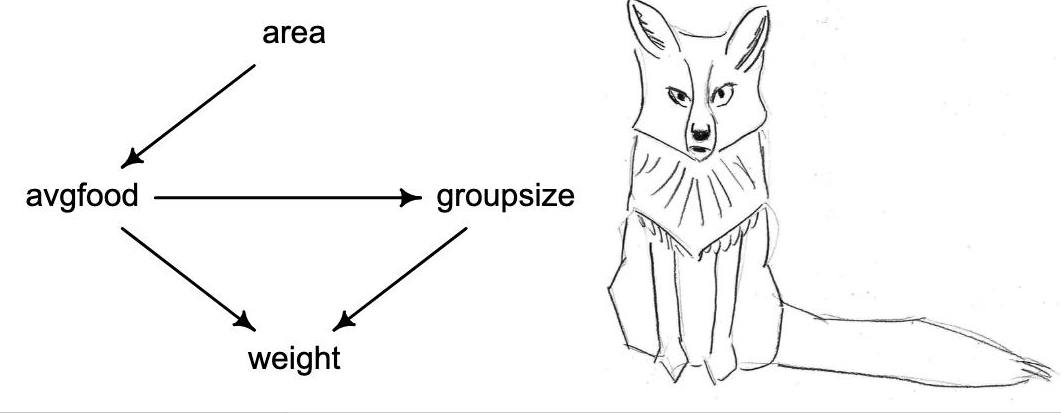


1. avgfood + groupsize + area
		
2. avgfood + groupsize
		
3. groupsize + area
		
4. avgfood
		
5. area 
	
	
Can you explain the relative differences in WAIC scores, using the fox DAG from last week’s homework? Be sure to pay attention to the standard error of the score differences (dSE).

dSE: Standard error of the difference in IC (Information Criterion) between each model and the top-ranked model. 

https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html

Not much difference between the model 4 or 5 because they are essentially the same inference-wise, they both omit groupsize.
And not much difference between models 2 and 3 because for inference it doesn't matter whether we use food or area, as long as we include gorupsize.  